In [1]:
import torch
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error
import scipy.stats as stats

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from core.dataset import DatasetLoader
from core.model import Model
from core.config import config
from core.logger import Logger

pd.set_option('display.max_columns', 20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f"Computational Device: {device}")
print(f"Target Variables: {config.columns.target_cols}")

Computational Device: cuda
Target Variables: ['target_days_to_payment']


In [3]:
project_root = os.getcwd()
data_path = os.path.join(project_root, config.paths.train_data)
runs_dir = os.path.join(project_root, "Runs")
available_runs = sorted(os.listdir(runs_dir))

for run in reversed(available_runs):
    checkpoint_path = os.path.join(runs_dir, run, "checkpoints", "best_model.pth")
    if os.path.exists(checkpoint_path):
        latest_run = run
        break

ema_checkpoint_path = os.path.join(runs_dir, latest_run, "checkpoints", "best_model_ema.pth")
use_ema = os.path.exists(ema_checkpoint_path)

print(f"Experiment Run: {latest_run}")
print(f"Checkpoint Path: {checkpoint_path}")
print(f"EMA Model: {'Available' if use_ema else 'Not Available'}")

Experiment Run: 20260127_222614
Checkpoint Path: c:\Users\Victo\OneDrive\Área de Trabalho\rental-churn - 2\rental-churn\Runs\20260127_222614\checkpoints\best_model.pth
EMA Model: Not Available


In [4]:
model_path = checkpoint_path
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
elif 'ema_state_dict' in checkpoint:
    state_dict = checkpoint['ema_state_dict']
else:
    state_dict = checkpoint

ckpt_embedding_dims = checkpoint.get('embedding_dimensions', None)

In [5]:
data_module = DatasetLoader(data_path, embedding_dimensions=ckpt_embedding_dims)
train_loader, validation_loader, test_loader = data_module.dataloader_pipeline()

target_scaler = data_module.target_scalers[config.columns.target_col_name]
continuous_scalers  = data_module.continuous_scalers

embedding_dims = data_module.embedding_dimensions
model = Model(embedding_dimensions=embedding_dims, num_continuous=len(data_module.continuous_columns))

model.load_state_dict(state_dict)
model.eval()


[08:48:03] [Experiment] DatasetLoader
[08:48:03] [Start] 2026-01-28 08:48:03
[08:48:03] [TensorBoard] Enabled
[08:48:03] 
[08:48:03] >>> DATALOADER PIPELINE
[08:48:03]   > Data Loading
[08:48:03] [Data Loading] Loading sequential data from: c:\Users\Victo\OneDrive\Área de Trabalho\rental-churn - 2\rental-churn\data/training_data.parquet
[08:48:07] [Data Loading] Loaded 6,433,244 rows, 61 columns
[08:48:08] [Data Loading] Sampled 3,000 users (out of 309,521), resulting in 63,491 rows

[08:48:08]   > Data Cleaning
[08:48:08]   > Feature Configuration
[08:48:08] [Clean] Categorical: 18 features
[08:48:08] [Clean] Continuous: 37 features
[08:48:08] [Clean] Targets: 1 (target_days_to_payment) 

[08:48:08]   > Target Clipping
[08:48:08] [Clean] Clipped target values to threshold=30: clipped 3,038 values

[08:48:08]   > Categorical Encoding
[08:48:08] [Categorical Encoding] Column recorrencia_pagamento     | cardinality=     2
[08:48:08] [Categorical Encoding] Column sexo                     

Model(
  (tokenizer): FeatureTokenizer(
    (categorical_embeddings): ModuleList(
      (0): Embedding(3, 128, padding_idx=0)
      (1): Embedding(4, 128, padding_idx=0)
      (2): Embedding(8, 128, padding_idx=0)
      (3): Embedding(7, 128, padding_idx=0)
      (4): Embedding(66, 128, padding_idx=0)
      (5): Embedding(25, 128, padding_idx=0)
      (6): Embedding(195, 128, padding_idx=0)
      (7): Embedding(77, 128, padding_idx=0)
      (8): Embedding(17, 128, padding_idx=0)
      (9): Embedding(8, 128, padding_idx=0)
      (10): Embedding(5, 128, padding_idx=0)
      (11-16): 6 x Embedding(3, 128, padding_idx=0)
      (17): Embedding(6, 128, padding_idx=0)
    )
    (embedding_dropout): Dropout(p=0.05, inplace=False)
    (continuous_embedding): FourierFeatures(
      (projection): Linear(in_features=128, out_features=128, bias=True)
      (gate): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (invoice_encoder): InvoiceEncoder(
    (layers): ModuleList(
      (0):

In [6]:
n_params = sum(p.numel() for p in model.parameters())
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model variant:        {'EMA' if use_ema else 'Standard'}")
print(f"Total parameters:     {n_params:,}")
print(f"Trainable parameters: {n_trainable:,}")

if 'epoch' in checkpoint:
    print(f"Training epochs:      {checkpoint['epoch']}")
if 'best_val_auc' in checkpoint:
    print(f"Best validation AUC:  {checkpoint['best_val_auc']:.4f}")

Model variant:        Standard
Total parameters:     909,249
Trainable parameters: 909,249


In [7]:
all_preds, all_targets, all_lengths = [], [], []

with torch.no_grad():
    for x_cat, x_cont, y, lengths in test_loader:   
        preds = model(x_cat, x_cont, lengths)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())
        all_lengths.extend(lengths.cpu().numpy())

preds_tensor = torch.cat(all_preds)
targets_tensor = torch.cat(all_targets)
seq_lengths = np.array(all_lengths)

den_targets = np.expm1(target_scaler.inverse_transform(targets_tensor.reshape(-1, 1)))
den_preds   = np.expm1(target_scaler.inverse_transform(preds_tensor.reshape(-1, 1)))

den_preds   = np.clip(den_preds, 0, None)
den_targets = np.clip(den_targets, 0, None)

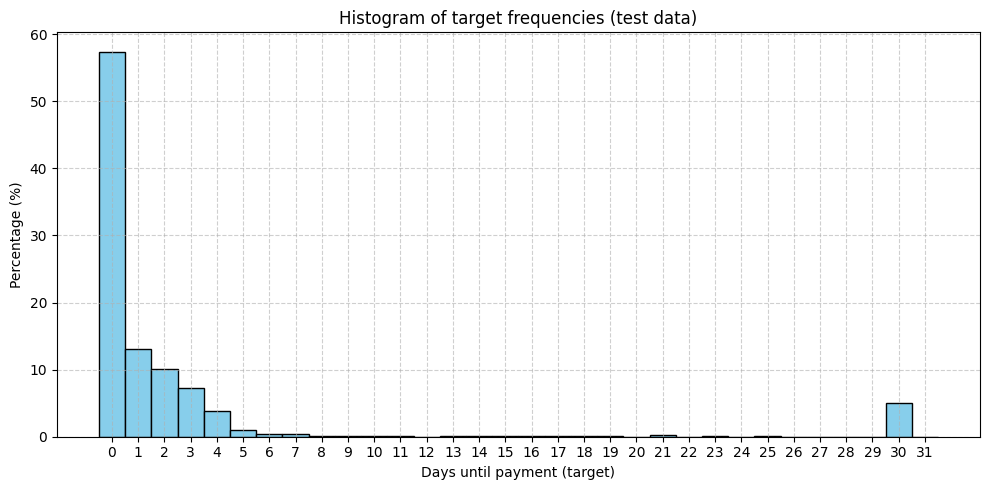

In [18]:
y = den_targets.ravel()
unique_vals = np.unique(y)
if np.allclose(unique_vals, np.round(unique_vals)) and len(unique_vals) <= 100:
    max_val = int(np.ceil(y.max()))
    bins = np.arange(0, max_val + 2) - 0.5
    xticks = np.arange(0, max_val + 1)
else:
    bins = 'auto'
    xticks = None

weights = np.ones_like(y) / len(y) * 100 

plt.figure(figsize=(10, 5))
plt.hist(y, bins=bins, weights=weights, color='skyblue', edgecolor='black')
plt.title('Histogram of target frequencies (test data)')
plt.xlabel('Days until payment (target)')
plt.ylabel('Percentage (%)')
if xticks is not None:
    plt.xticks(xticks)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [8]:

mae = np.mean(np.abs(den_preds - den_targets))
rmse = np.sqrt(np.mean((den_preds - den_targets) ** 2))
ss_res = np.sum((den_targets - den_preds) ** 2)
ss_tot = np.sum((den_targets - np.mean(den_targets)) ** 2)
r2 = 1 - ss_res / ss_tot if ss_tot != 0 else float('nan')
std = np.std(den_targets - den_preds)
mape = mean_absolute_percentage_error(den_targets, den_preds)
medae = median_absolute_error(den_targets, den_preds)
max_error = np.max(np.abs(den_targets - den_preds))

error_bin_0_5      = np.mean(np.abs(den_targets - den_preds) <= 5) * 100
error_bin_5_10     = np.mean((np.abs(den_targets - den_preds) > 5) & (np.abs(den_targets - den_preds) <= 10)) * 100
error_bin_10_15    = np.mean((np.abs(den_targets - den_preds) > 10) & (np.abs(den_targets - den_preds) <= 15)) * 100
error_bin_15_20    = np.mean((np.abs(den_targets - den_preds) > 15) & (np.abs(den_targets - den_preds) <= 20)) * 100
error_bin_20_25    = np.mean((np.abs(den_targets - den_preds) > 20) & (np.abs(den_targets - den_preds) <= 25)) * 100
error_bin_above_25 = np.mean(np.abs(den_targets - den_preds) > 25) * 100

error_target_0_5 = np.mean(np.abs(den_targets - den_preds)[den_targets.flatten() <= 5])
error_target_5_10 = np.mean(np.abs(den_targets - den_preds)[(den_targets.flatten() > 5) & (den_targets.flatten() <= 10)])
error_target_10_15 = np.mean(np.abs(den_targets - den_preds)[(den_targets.flatten() > 10) & (den_targets.flatten() <= 15)])
error_target_15_20 = np.mean(np.abs(den_targets - den_preds)[(den_targets.flatten() > 15) & (den_targets.flatten() <= 20)])
error_target_20_25 = np.mean(np.abs(den_targets - den_preds)[(den_targets.flatten() > 20) & (den_targets.flatten() <= 25)])
error_target_above_25 = np.mean(np.abs(den_targets - den_preds)[den_targets.flatten() > 25])

In [9]:
print(f"Sequence length - Min: {seq_lengths.min()}, Max: {seq_lengths.max()}, Mean: {seq_lengths.mean():.1f}")
print(f"\nTarget Distribution:")

print(f"\nRegression Metrics:")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²:   {r2:.4f}")
print(f"  STD:  {std:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  MedAE:{medae:.4f}")
print(f"  Max Error: {max_error:.4f}")

print(f"\nError Distribution (% of samples):")
print(f"  |Error| <= 5:    {error_bin_0_5:.2f}%")
print(f"  5 < |Error| <=10:{error_bin_5_10:.2f}%")
print(f"  10< |Error| <=15:{error_bin_10_15:.2f}%")
print(f"  15< |Error| <=20:{error_bin_15_20:.2f}%")
print(f"  20< |Error| <=25:{error_bin_20_25:.2f}%")
print(f"  |Error| >  25:   {error_bin_above_25:.2f}%")

print(f"\nMean Absolute Error by Target Bins:")
print(f"  Target <= 5:     {error_target_0_5:.4f}")
print(f"  5 < Target <=10: {error_target_5_10:.4f}")
print(f"  10< Target <=15: {error_target_10_15:.4f}")
print(f"  15< Target <=20: {error_target_15_20:.4f}")
print(f"  20< Target <=25: {error_target_20_25:.4f}")
print(f"  Target >  25:    {error_target_above_25:.4f}")

Sequence length - Min: 10, Max: 50, Mean: 32.5

Target Distribution:

Regression Metrics:
  MAE:  0.7030
  RMSE: 1.6934
  R²:   0.9370
  STD:  1.6933
  MAPE: 1072180282256262.6250
  MedAE:0.2879
  Max Error: 28.5918

Error Distribution (% of samples):
  |Error| <= 5:    98.89%
  5 < |Error| <=10:0.58%
  10< |Error| <=15:0.29%
  15< |Error| <=20:0.10%
  20< |Error| <=25:0.02%
  |Error| >  25:   0.12%

Mean Absolute Error by Target Bins:
  Target <= 5:     0.5963
  5 < Target <=10: 2.7273
  10< Target <=15: 7.6942
  15< Target <=20: 8.0207
  20< Target <=25: 3.6995
  Target >  25:    0.9368


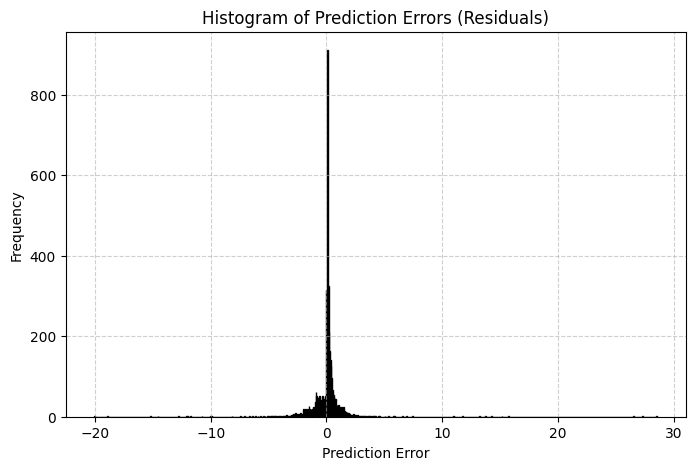

In [10]:
errors = np.ravel(den_preds - den_targets)

plt.figure(figsize=(8, 5))
plt.hist(errors, bins='auto', color='skyblue', edgecolor='black')
plt.title('Histogram of Prediction Errors (Residuals)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

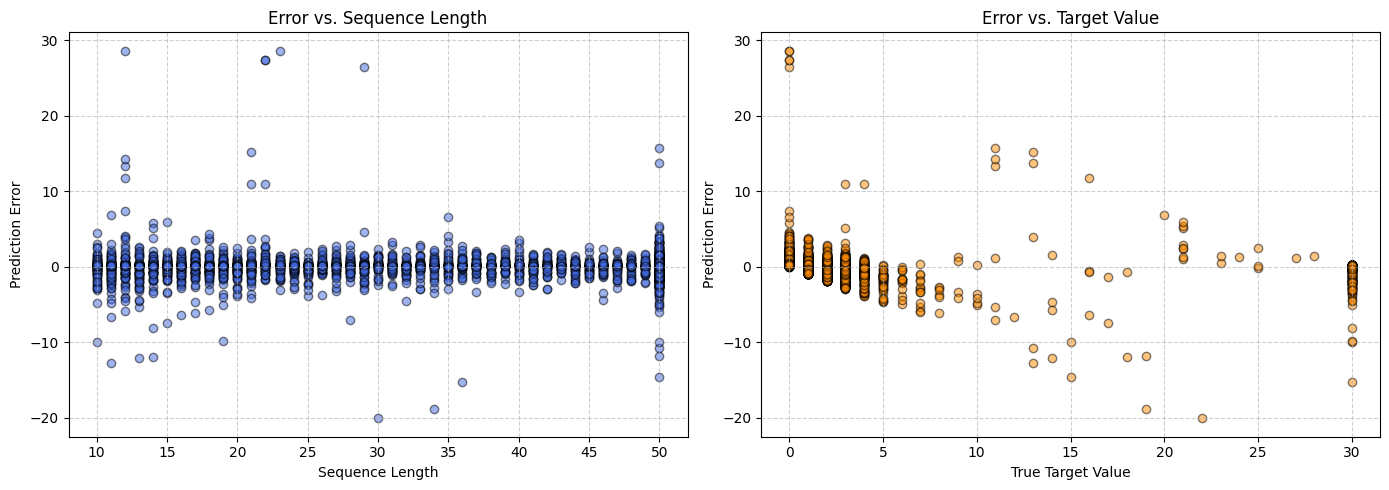

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(seq_lengths, errors, alpha=0.5, color='royalblue', edgecolor='k')
axes[0].set_title('Error vs. Sequence Length')
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Prediction Error')
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].scatter(den_targets, errors, alpha=0.5, color='darkorange', edgecolor='k')
axes[1].set_title('Error vs. Target Value')
axes[1].set_xlabel('True Target Value')
axes[1].set_ylabel('Prediction Error')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

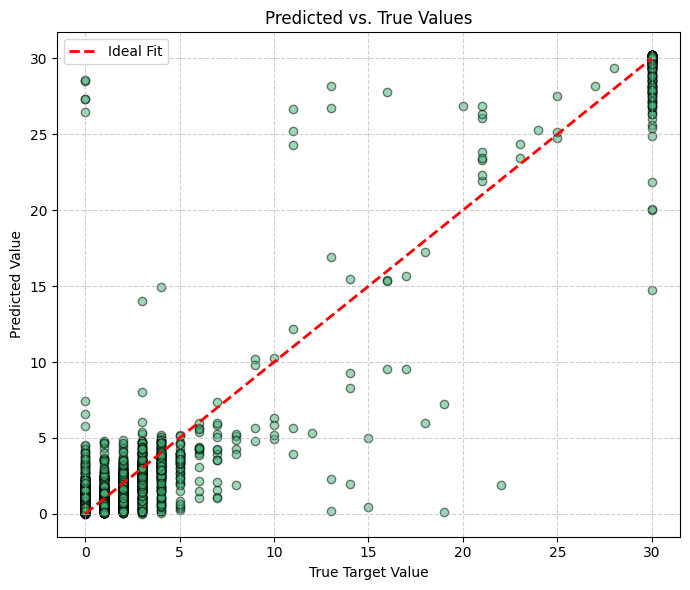

In [12]:
plt.figure(figsize=(7, 6))
plt.scatter(den_targets, den_preds, alpha=0.5, color='mediumseagreen', edgecolor='k')
plt.plot([den_targets.min(), den_targets.max()], [den_targets.min(), den_targets.max()], 'r--', lw=2, label='Ideal Fit')
plt.title('Predicted vs. True Values')
plt.xlabel('True Target Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

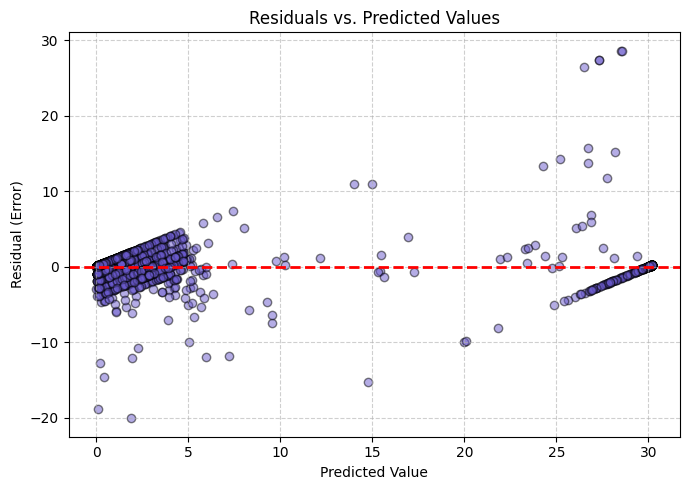

In [13]:
plt.figure(figsize=(7, 5))
plt.scatter(den_preds, errors, alpha=0.5, color='slateblue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Value')
plt.ylabel('Residual (Error)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

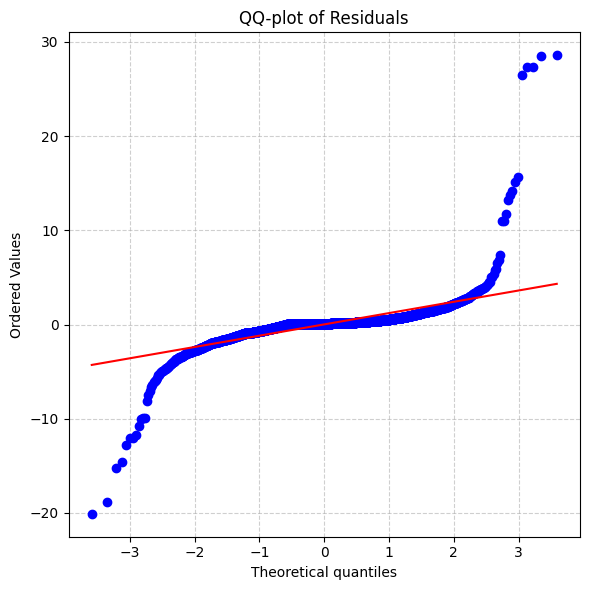

In [14]:
plt.figure(figsize=(6, 6))
stats.probplot(errors, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

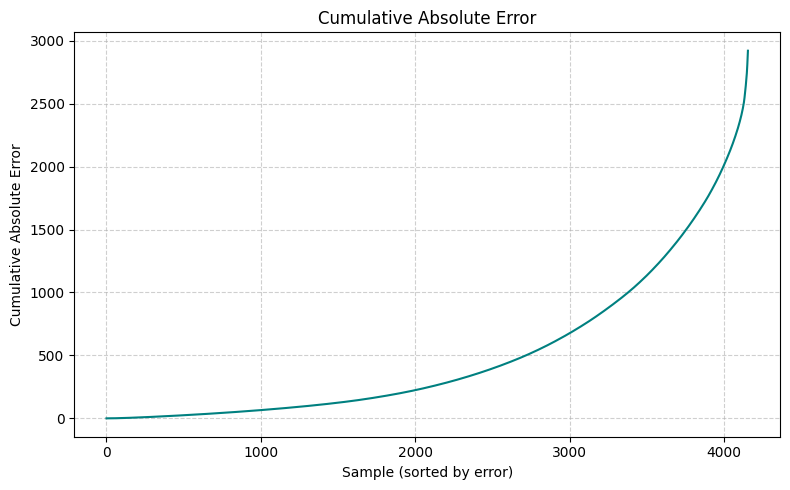

In [15]:
sorted_abs_errors = np.sort(np.abs(errors))
cum_abs_error = np.cumsum(sorted_abs_errors)
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_abs_error)+1), cum_abs_error, color='teal')
plt.title('Cumulative Absolute Error')
plt.xlabel('Sample (sorted by error)')
plt.ylabel('Cumulative Absolute Error')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()